In [36]:
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F

In [2]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [3]:
model = UNet(n_channels=1, n_classes=1).float()

In [4]:
model.load_state_dict(torch.load("model_cifar.pt"))

<All keys matched successfully>

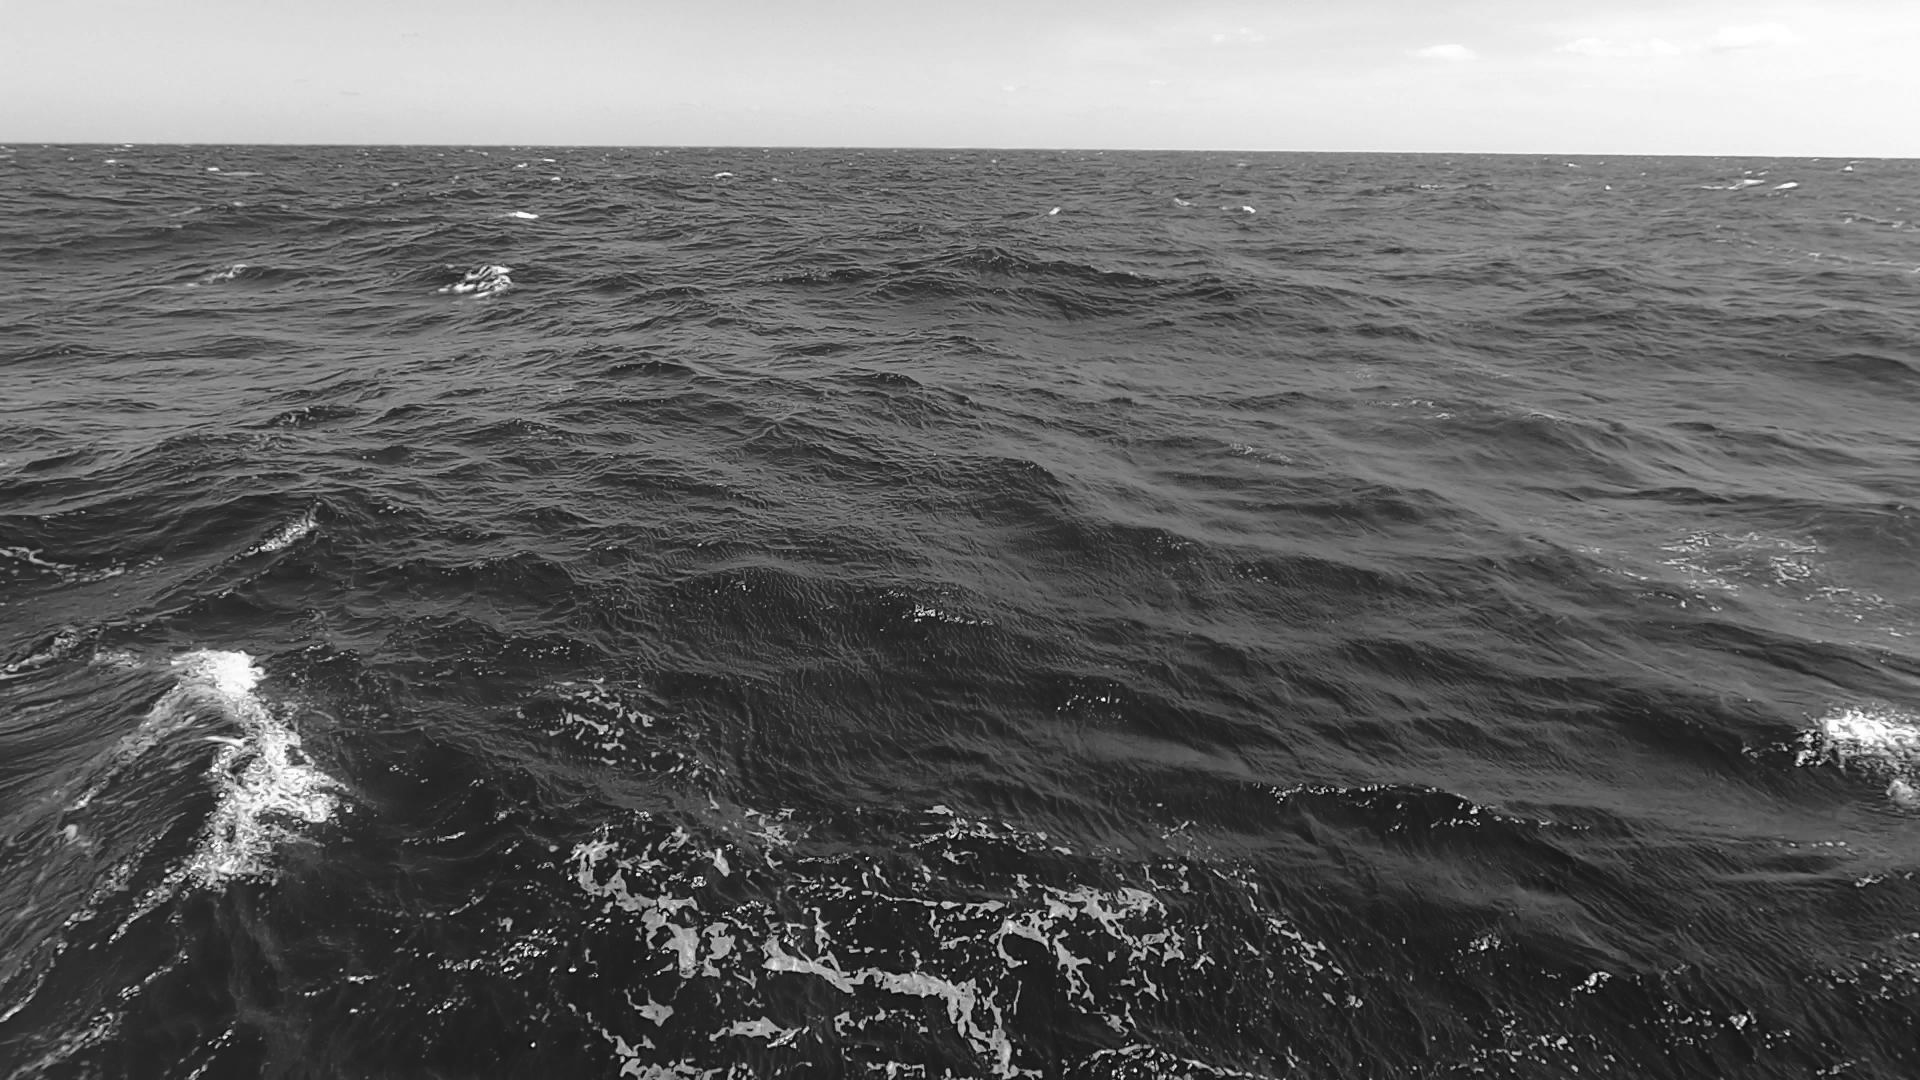

In [14]:
from PIL import Image
from pathlib import Path


img = Image.open('E:/GoPro_deep/image/GH020008/img00030.jpg').convert('L')
img

In [37]:
import numpy as np
pix = np.array(img.getdata()).reshape(img.size[1], img.size[0])

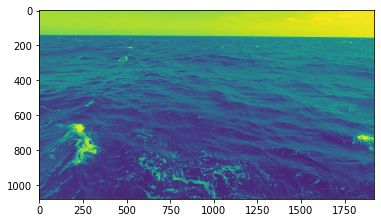

In [38]:
import matplotlib.pyplot as plt

plt.imshow(pix)

In [44]:
roi = pix[400:900, 0:1920]

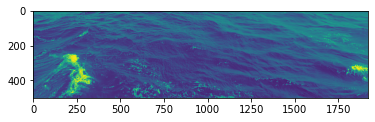

In [45]:
plt.imshow(roi)

In [46]:
roi_tensor = torch.from_numpy(roi / 255).float()

In [47]:
roi_tensor = roi_tensor.unsqueeze(0)
roi_tensor = roi_tensor.unsqueeze(0)

In [48]:
roi_tensor.shape

torch.Size([1, 1, 500, 1920])

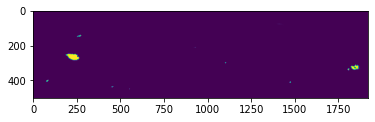

In [67]:
output = model(roi_tensor)
output = output.squeeze(0)
output = output.squeeze(0)
plt.imshow(output.detach().numpy())

In [55]:
np.max(output.detach().numpy())

0.9999621

(array([[500.,   0.,   0., ...,   0.,   0.,   0.],
        [500.,   0.,   0., ...,   0.,   0.,   0.],
        [500.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [500.,   0.,   0., ...,   0.,   0.,   0.],
        [500.,   0.,   0., ...,   0.,   0.,   0.],
        [500.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([1.3840412e-09, 9.9996209e-02, 1.9999242e-01, 2.9998863e-01,
        3.9998484e-01, 4.9998105e-01, 5.9997725e-01, 6.9997346e-01,
        7.9996967e-01, 8.9996588e-01, 9.9996209e-01], dtype=float32),
 <a list of 1920 BarContainer objects>)

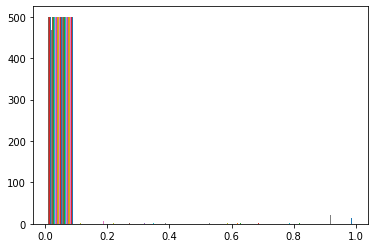

In [56]:
plt.hist(output.detach().numpy())

In [74]:
output_test = output.detach().numpy()
output_test[output_test < 0.1] = 0
output_test[output_test > 0.9] = 1

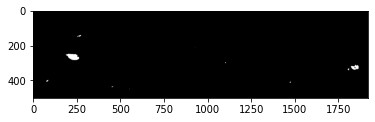

In [75]:
plt.imshow(output_test, cmap='gray')

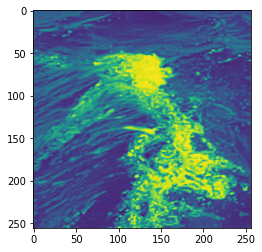

In [18]:
pix = pix[600:856, 100:356]
plt.imshow(pix)

In [19]:
pix_tensor = torch.from_numpy(pix / 255).float()

In [20]:
pix_tensor.shape

torch.Size([256, 256])

In [21]:
pix_tensor = pix_tensor.unsqueeze(0)

In [25]:
pix_tensor = pix_tensor.unsqueeze(0)

In [26]:
pix_tensor.shape

torch.Size([1, 1, 256, 256])

In [28]:
output = model(pix_tensor)

In [29]:
output.shape

torch.Size([1, 1, 256, 256])

In [30]:
output = output.squeeze(0)

In [31]:
output = output.squeeze(0)

In [32]:
output.shape

torch.Size([256, 256])

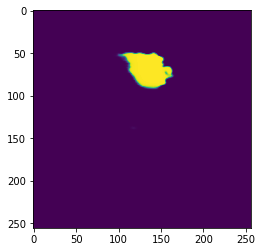

In [33]:
plt.imshow(output.detach().numpy())

In [34]:
pix.shape

(256, 256)